# Análisis Exploratorio de Datos para la Detección de Fraudes en Transacciones Financieras
### **Autores:**
- Marco Antonio Jurado carnet 20308

### **Fecha:**
- 24/5/2024

### **Resumen:**
Este documento presenta un análisis detallado de datos transaccionales con el objetivo de identificar patrones y características relevantes para la detección de fraudes. Se utilizan diversas técnicas de análisis exploratorio de datos (EDA).

Debes de correr esta celda para instalar algunas de las dependencias si en dado caso no las tuvieras instaladas en tu operador.

In [25]:
#!pip install lightgbm
#!pip install --upgrade lightgbm
#!pip install category_encoders
#!pip install geopy

Comenzamos haciendo los imports de las librerias que nos estarán dando el apoyo en todo el análisis exploratorio de nuestros datos

In [26]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from geopy.distance import geodesic
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

Comenzamos abriendo nuestro set de datos alojado con el nombre de fraud_feature_engineering_example en formato csv. Este contiene data dummy que estaremos analizando para comprender la naturaleza del set

In [27]:
data = pd.read_csv('fraud_feature_engineering_example.csv')
data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'amt_month', 'amt_year',
       'amt_month_shopping_net_spend', 'count_month_shopping_net',
       'first_time_at_merchant'],
      dtype='object')

In [28]:
data.shape

(1852394, 27)

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 27 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   trans_date_trans_time         object 
 1   cc_num                        int64  
 2   merchant                      object 
 3   category                      object 
 4   amt                           float64
 5   first                         object 
 6   last                          object 
 7   gender                        object 
 8   street                        object 
 9   city                          object 
 10  state                         object 
 11  zip                           int64  
 12  lat                           float64
 13  long                          float64
 14  city_pop                      int64  
 15  job                           object 
 16  dob                           object 
 17  trans_num                     object 
 18  unix_time             

In [30]:
data["merchant"].value_counts()

fraud_Kilback LLC                        6262
fraud_Cormier LLC                        5246
fraud_Schumm PLC                         5195
fraud_Kuhn LLC                           5031
fraud_Boyer PLC                          4999
                                         ... 
fraud_Douglas, DuBuque and McKenzie      1101
fraud_Treutel-King                       1098
fraud_Satterfield-Lowe                   1095
fraud_Hahn, Douglas and Schowalter       1091
fraud_Ritchie, Bradtke and Stiedemann    1090
Name: merchant, Length: 693, dtype: int64

In [31]:
data["is_fraud"].value_counts()

0    1842743
1       9651
Name: is_fraud, dtype: int64

Aqui podemos ver la distribución del monto de las transacciones en el set de datos. Esto nos permite ver en que rango podemos encontrar las transacciones y saber si hay datos atípicos en el mismo set.

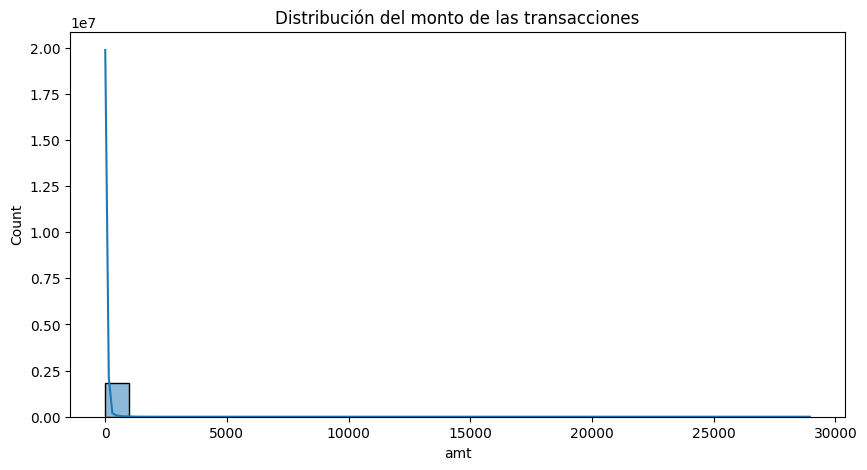

In [32]:
plt.figure(figsize=(10, 5))
sns.histplot(data['amt'], bins=30, kde=True)
plt.title('Distribución del monto de las transacciones')
plt.show()

Aqui nos vamos a centrar un poco más a detalle en nuestra variable de interés. Vamos especificamente por la distribución pero en la variable que sí es fraude.

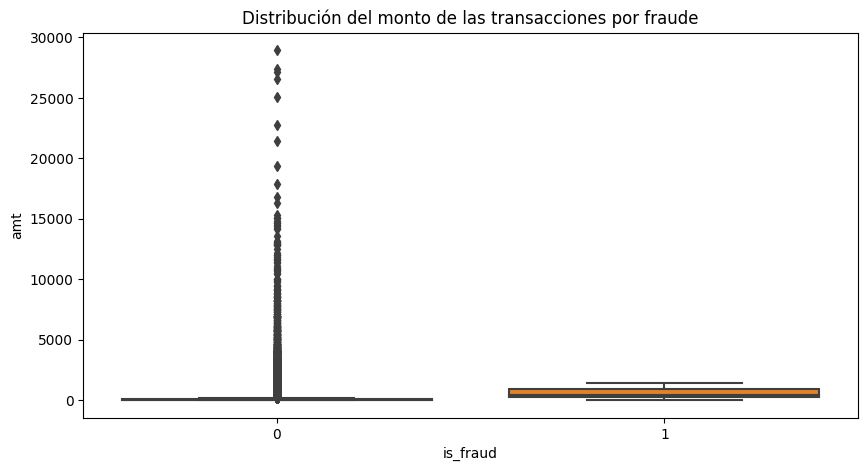

In [33]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='is_fraud', y='amt', data=data)
plt.title('Distribución del monto de las transacciones por fraude')
plt.show()

Vamos a determinar un poco cómo es que están distribuidas las transacciones. Estas tienen una clase de agrupación?

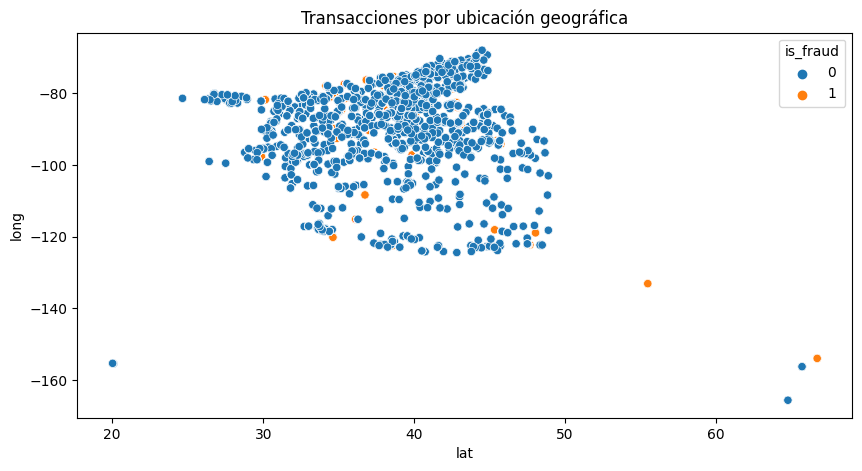

In [34]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='lat', y='long', hue='is_fraud', data=data)
plt.title('Transacciones por ubicación geográfica')
plt.show()

Veremos un poco la correlación de las variables en el set de datos con la matriz de correlación.

C:\Users\marco\AppData\Local\Temp\ipykernel_63240\3998509331.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


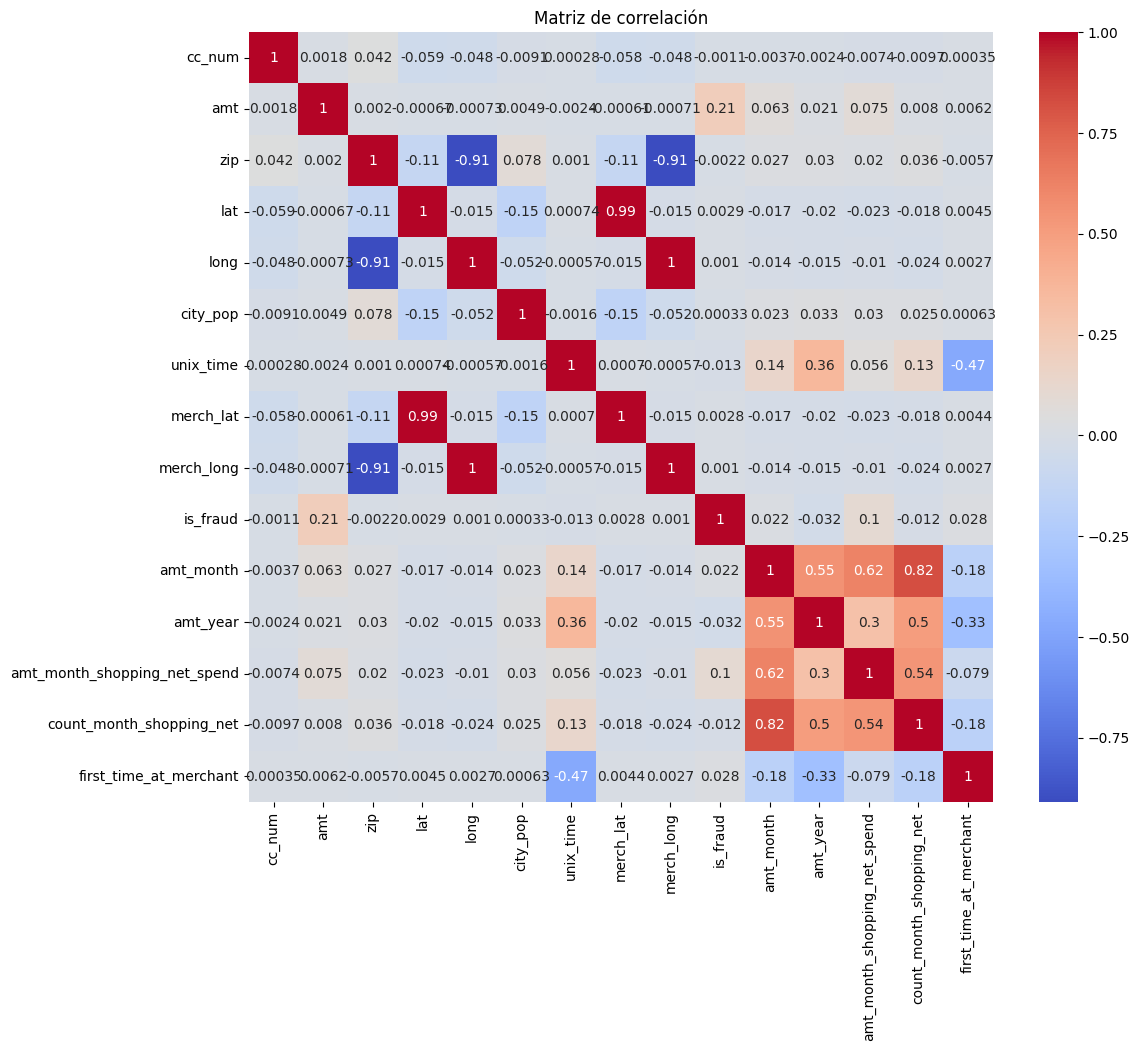

In [35]:
plt.figure(figsize=(12, 10))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()

¿Tenemos valores nulos en el set?

In [36]:
missing_values = data.isnull().sum()
print("Valores nulos en cada columna:\n", missing_values)

Valores nulos en cada columna:
 trans_date_trans_time           0
cc_num                          0
merchant                        0
category                        0
amt                             0
first                           0
last                            0
gender                          0
street                          0
city                            0
state                           0
zip                             0
lat                             0
long                            0
city_pop                        0
job                             0
dob                             0
trans_num                       0
unix_time                       0
merch_lat                       0
merch_long                      0
is_fraud                        0
amt_month                       0
amt_year                        0
amt_month_shopping_net_spend    0
count_month_shopping_net        0
first_time_at_merchant          0
dtype: int64


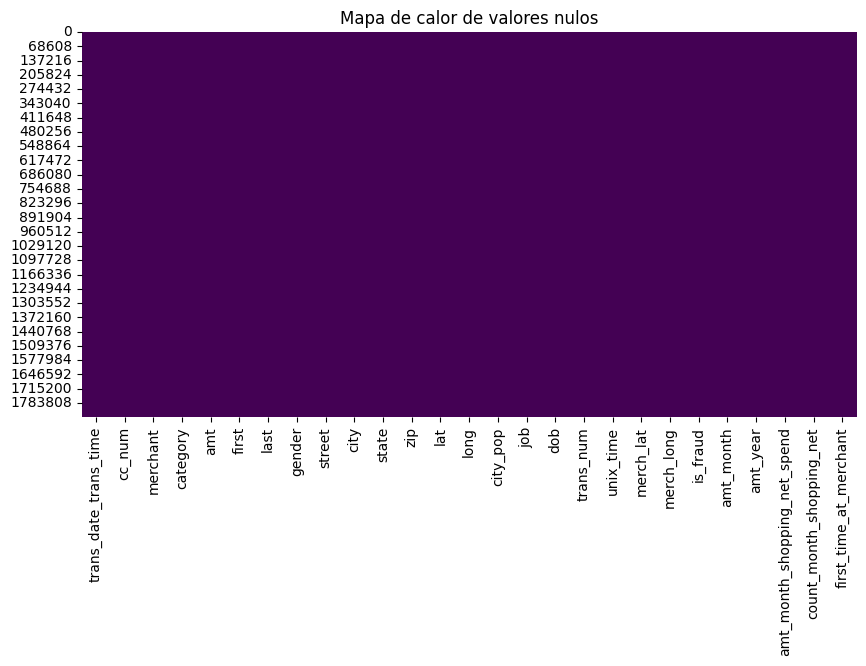

In [37]:
plt.figure(figsize=(10, 5))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Mapa de calor de valores nulos')
plt.show()

Vamos a ver los montos por transacción en un boxplot. Esto nos permite visualizar la data un poco mejor.

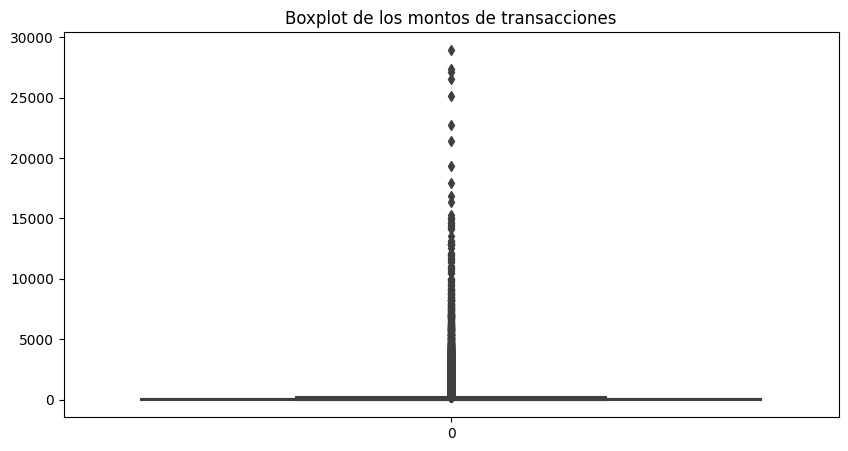

In [38]:
plt.figure(figsize=(10, 5))
sns.boxplot(data['amt'])
plt.title('Boxplot de los montos de transacciones')
plt.show()

Veremos las transacciones mensuales. Puede que el total mensual nos de un dato curioso sobre como esta distribuido los gastos por mes en el set.

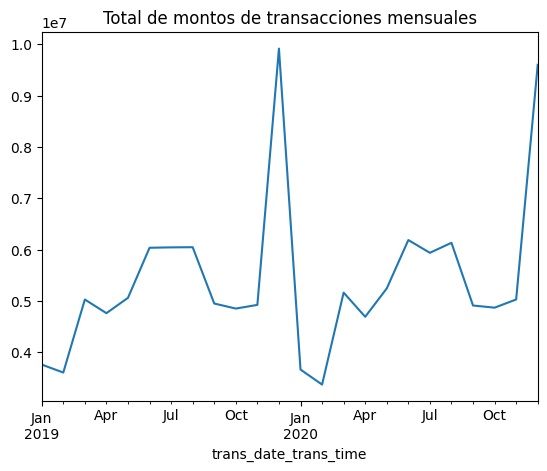

In [39]:
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
data.set_index('trans_date_trans_time', inplace=True)
data['amt'].resample('M').sum().plot()
plt.title('Total de montos de transacciones mensuales')
plt.show()

¿Cómo se distribuyen las categorías?

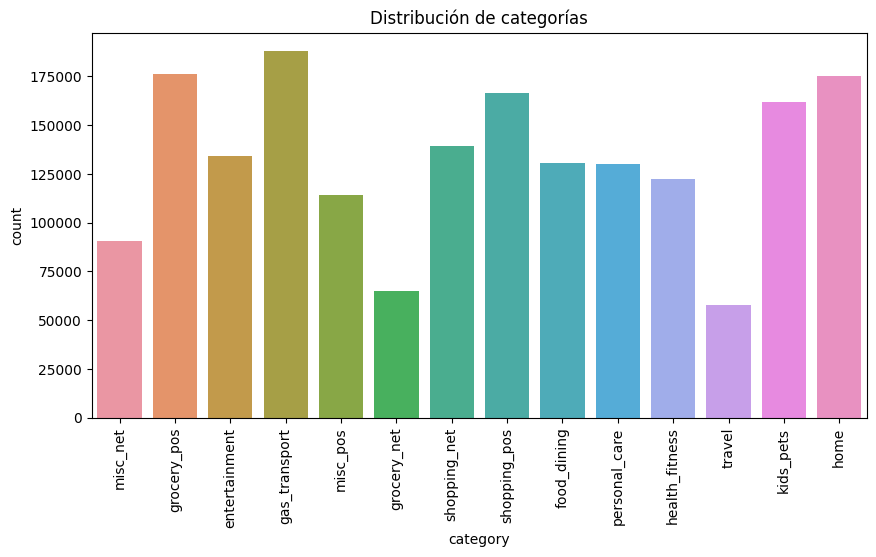

In [40]:
plt.figure(figsize=(10, 5))
sns.countplot(x='category', data=data)
plt.title('Distribución de categorías')
plt.xticks(rotation=90)
plt.show()

¿Podemos agrupar nuestro set dada su ubicación en clústers?

C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


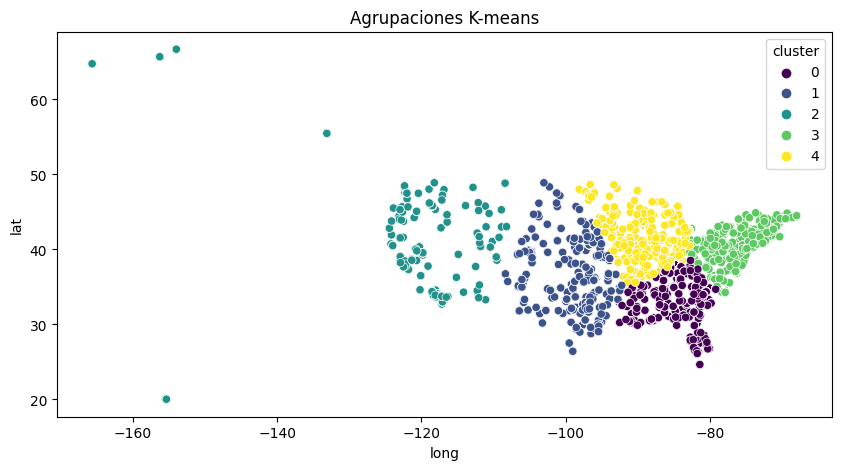

In [41]:
X = data[['lat', 'long']]
kmeans = KMeans(n_clusters=5, random_state=42).fit(X)
data['cluster'] = kmeans.labels_

plt.figure(figsize=(10, 5))
sns.scatterplot(x='long', y='lat', hue='cluster', data=data, palette='viridis')
plt.title('Agrupaciones K-means')
plt.show()

Veremos si hay una tendencia a fraudes por mes

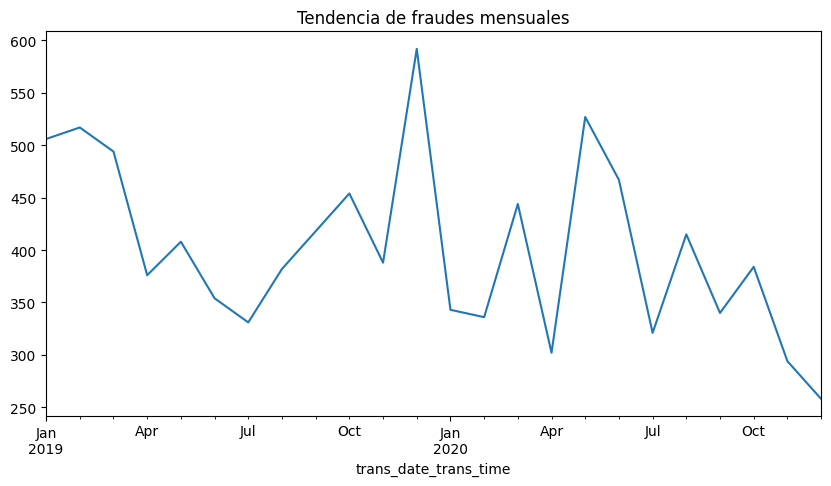

In [42]:
fraud_trend = data['is_fraud'].resample('M').sum()
plt.figure(figsize=(10, 5))
fraud_trend.plot()
plt.title('Tendencia de fraudes mensuales')
plt.show()

¿Hay un comerciante que tenga muchas transacciones fraudulentas?

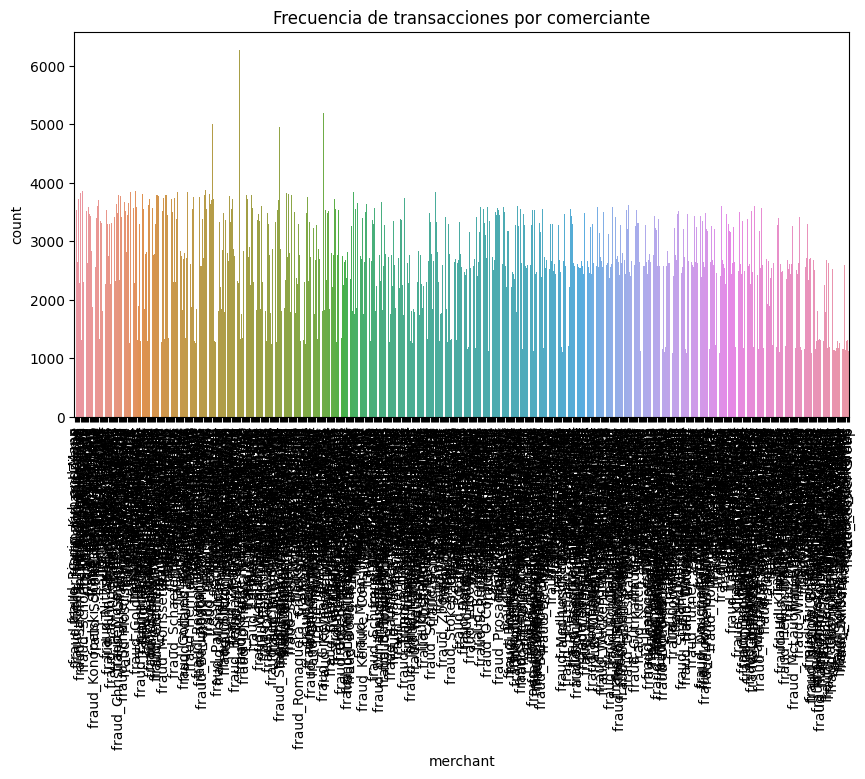

In [43]:
plt.figure(figsize=(10, 5))
sns.countplot(x='merchant', data=data)
plt.title('Frecuencia de transacciones por comerciante')
plt.xticks(rotation=90)
plt.show()

Finalmente veamos la distancia entre el comprador y el comerciante

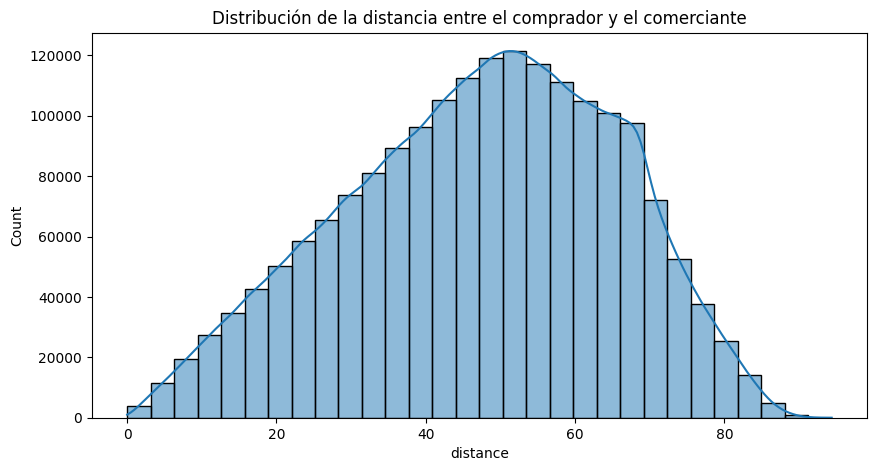

In [44]:
data['distance'] = data.apply(lambda row: geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).miles, axis=1)
plt.figure(figsize=(10, 5))
sns.histplot(data['distance'], bins=30, kde=True)
plt.title('Distribución de la distancia entre el comprador y el comerciante')
plt.show()